# Week 08 - Chaotic Pendulum

Domingo, Kenneth V.<br />
2015-03116

Primary references:
1. Kinzel, W., and G. Reents (1998). Chaotic pendulum. In M. Clajus, and B. Freeland-Clajus (Trans.), <i>Physics by computer: Programming physical problems using Mathematica and C</i> (pp. 121-130). New York: Springer (Original work published 1996).

In [1]:
import numpy as np
import matplotlib.pyplot as mp
import matplotlib.animation as anim
import scipy.integrate as integ

%matplotlib inline
mp.rc("text", usetex=True)

In [2]:
def polarticks_2(value,tick_number):
    N = int(np.round(2*value/np.pi))
    if N == 0:
        return r"$0$"
    elif N == -1:
        return r"$-\pi/2$"
    elif N == 1:
        return r"$\pi/2$"
    elif N == -2:
        return r"$-\pi$"
    elif N == 2:
        return r"$\pi$"
    elif N%2 < 0:
        return r"$-{0}\pi/2$".format(N)
    elif N%2 > 0 or N%2 < 0:
        return r"${0}\pi/2$".format(N)
    else:
        return r"${0}\pi$".format(N//2)
    
def polarticks_1(value,tick_number):
    N = int(np.round(value/np.pi))
    if N == 0:
        return r"$0$"
    elif N == -1:
        return r"$-\pi$"
    elif N == 1:
        return r"$\pi$"
    else:
        return r"${0}\pi$".format(N)

In [24]:
class rksolve(object):
    
    def __init__(self,derivs,wd):
        self.derivs = derivs
        self.wd = wd
        self.init_conds = None
        self.phase_solution = None
        self.poincare_solution = None
    
    def rk4(self,ta,tb,N=1000):
        derivs = self.derivs
        wd = self.wd
        y0 = np.array(self.init_conds, float)
        h = (tb-ta)/N
        tpoints = np.arange(ta,tb,h)
        phase_solution = np.zeros(tpoints.shape + y0.shape, float)
        y = y0
        
        for i,t in enumerate(tpoints):
            phase_solution[i] = y
            k1 = h*derivs(y,t)
            k2 = h*derivs(y + 1/2*k1, t + 1/2*h)
            k3 = h*derivs(y + 1/2*k2, t + 1/2*h)
            k4 = h*derivs(y + k3, t + h)
            y += 1/6*(k1 + 2*k2 + 2*k3 + k4)
        self.h = h
        self.phase_solution = phase_solution
        self.t = tpoints
        
        derivs = self.derivs
        y0 = np.array(self.init_conds, float)
        h = (tb-ta)/N
        y = y0
        tjpoints = np.arange(0,N) * 2*np.pi/wd
        poincare_solution = np.zeros(tjpoints.shape + y0.shape, float)
        y = y0
        for i,t in enumerate(tjpoints):
            poincare_solution[i] = y
            k1 = h*derivs(y,t)
            k2 = h*derivs(y + 1/2*k1, t + 1/2*h)
            k3 = h*derivs(y + 1/2*k2, t + 1/2*h)
            k4 = h*derivs(y + k3, t + h)
            y += 1/6*(k1 + 2*k2 + 2*k3 + k4)
        self.h = h
        self.poincare_solution = poincare_solution
        self.tj = tjpoints
          
class rksolve_generalized(object):
    
    def __init__(self,f):
        self.f = f
        self.init_conds = None
        self.phase_solution = None
    
    def rk4(self,ta,tb,N=1000):
        """
        Perform Runge-Kutta stage-4 (RK4) integration of a time-varying system for
        an arbitrary number of variables/dimensions. Use rk4_spec to specify exact
        step size.

        Parameters
        ----------
        ta : float
            Time to begin integration
        tb : float
            Time to end integration
        N : int
            Number of integration steps to perform from ta to tb. Step size h is
            determined by
            
                    tb - ta
            h = ----------------
                        N
        
        Returns
        -------
        phase_solution : array_like
            Array of solutions in the specified space. The columns represent
            the state of the system at each time step for each variable.
        """
        f = self.f
        r0 = np.array(self.init_conds, float)
        h = (tb-ta)/N
        tpoints = np.arange(ta,tb,h)
        phase_solution = np.zeros(tpoints.shape + r0.shape, float)
        r = r0
        for i,t in enumerate(tpoints):
            phase_solution[i] = r
            k1 = h*f(r,t)
            k2 = h*f(r + 1/2*k1, t + 1/2*h)
            k3 = h*f(r + 1/2*k2, t + 1/2*h)
            k4 = h*f(r + k3, t + h)
            r += 1/6*(k1 + 2*k2 + 2*k3 + k4)
        self.h = h
        self.phase_solution = phase_solution
        self.t = tpoints
        
    def rk4_spec(self,ta,tb,dt):
        f = self.f
        r0 = np.array(self.init_conds, float)
        h = dt
        tpoints = np.arange(ta,tb,h)
        phase_solution = np.zeros(tpoints.shape + r0.shape, float)
        r = r0
        for i,t in enumerate(tpoints):
            phase_solution[i] = r
            k1 = h*f(r,t)
            k2 = h*f(r + 1/2*k1, t + 1/2*h)
            k3 = h*f(r + 1/2*k2, t + 1/2*h)
            k4 = h*f(r + k3, t + h)
            r += 1/6*(k1 + 2*k2 + 2*k3 + k4)
        self.h = h
        self.phase_solution = phase_solution
        self.t = tpoints

In [4]:
def pendulum(a, r, wd):
    
    def derivs(y,t):
        theta,omega = y
        ftheta = omega
        fomega = -r*y[1] - np.sin(y[0]) + a*np.cos(wd * t)
        return np.array([ftheta,fomega], float)
    
    prob = rksolve(derivs,wd)
    y0 = np.array([ np.pi/2 , 0 ], float)
    prob.init_conds = y0
    prob.rk4(0, 30*60, int(1e4))
    x = prob.phase_solution[:,0]
    y = prob.phase_solution[:,1]
    xp = prob.poincare_solution[:,0]
    yp = prob.poincare_solution[:,1]
    return x,y,xp,yp

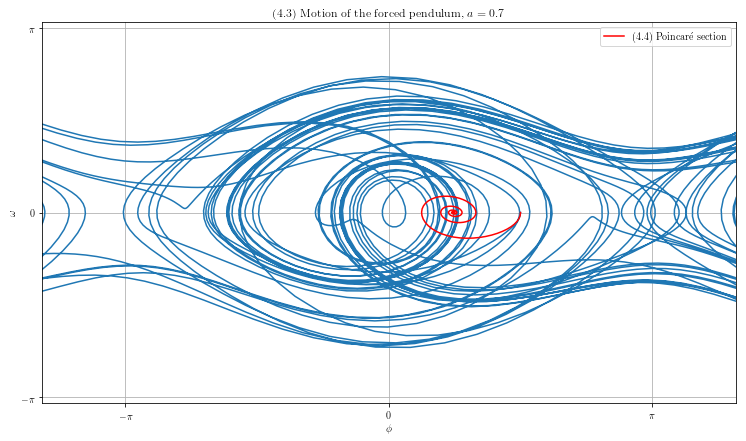

In [8]:
x,y,xp,yp = pendulum(0.7, 0.25, 2/3)

fig,ax = mp.subplots(figsize=(7*16/9,7))

ax.plot(x,y)
ax.plot(xp,yp, "r-", label=r"\textrm{(4.4) Poincar\'{e} section}")

ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\omega$")
ax.set_title(r"\textrm{(4.3) Motion of the forced pendulum, $a=0.7$}")
ax.set_xlim(-np.pi-1,np.pi+1)
ax.set_ylim(-np.pi-0.1,np.pi+0.1)
ax.xaxis.set_major_formatter(mp.FuncFormatter(polarticks_1))
ax.xaxis.set_major_locator(mp.MultipleLocator(np.pi))
ax.yaxis.set_major_formatter(mp.FuncFormatter(polarticks_1))
ax.yaxis.set_major_locator(mp.MultipleLocator(np.pi))
ax.grid(True)

ax.legend()
mp.show()

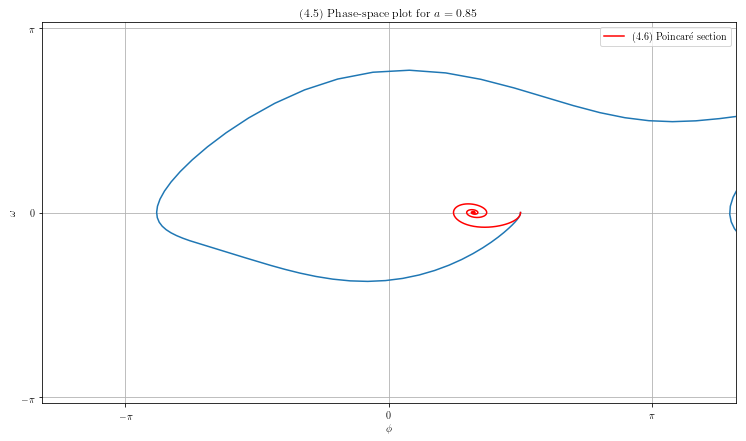

In [7]:
x,y,xp,yp = pendulum(0.85, 0.25, 2/3)

fig,ax = mp.subplots(figsize=(7*16/9,7))
ax.plot(x,y)
ax.plot(xp,yp, "r-", label=r"\textrm{(4.6) Poincar\'{e} section}")
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\omega$")
ax.set_title(r"\textrm{(4.5) Phase-space plot for $a=0.85$}")
ax.set_xlim(-np.pi-1,np.pi+1)
ax.set_ylim(-np.pi-0.1,np.pi+0.1)
ax.xaxis.set_major_formatter(mp.FuncFormatter(polarticks_1))
ax.xaxis.set_major_locator(mp.MultipleLocator(np.pi))
ax.yaxis.set_major_formatter(mp.FuncFormatter(polarticks_1))
ax.yaxis.set_major_locator(mp.MultipleLocator(np.pi))
ax.grid(True)

ax.legend()
mp.show()

In [9]:
def lorenz(sigma=10, rho=28, beta=8/3):
    
    def f(r,t):
        X,Y,Z = r
        fX = -sigma*X + sigma*Y
        fY = -X*Z + rho*X - Y
        fZ = X*Y - beta*Z
        return np.array([fX,fY,fZ], float)
    
    prob = rksolve_generalized(f)
    r0 = np.array([ 0.0 , 1.0 , 0.0 ], float)
    prob.init_conds = r0
    prob.rk4(0.0, 50.0, int(1e4))
    x = prob.phase_solution[:,0]
    y = prob.phase_solution[:,1]
    z = prob.phase_solution[:,2]
    return x,y,z

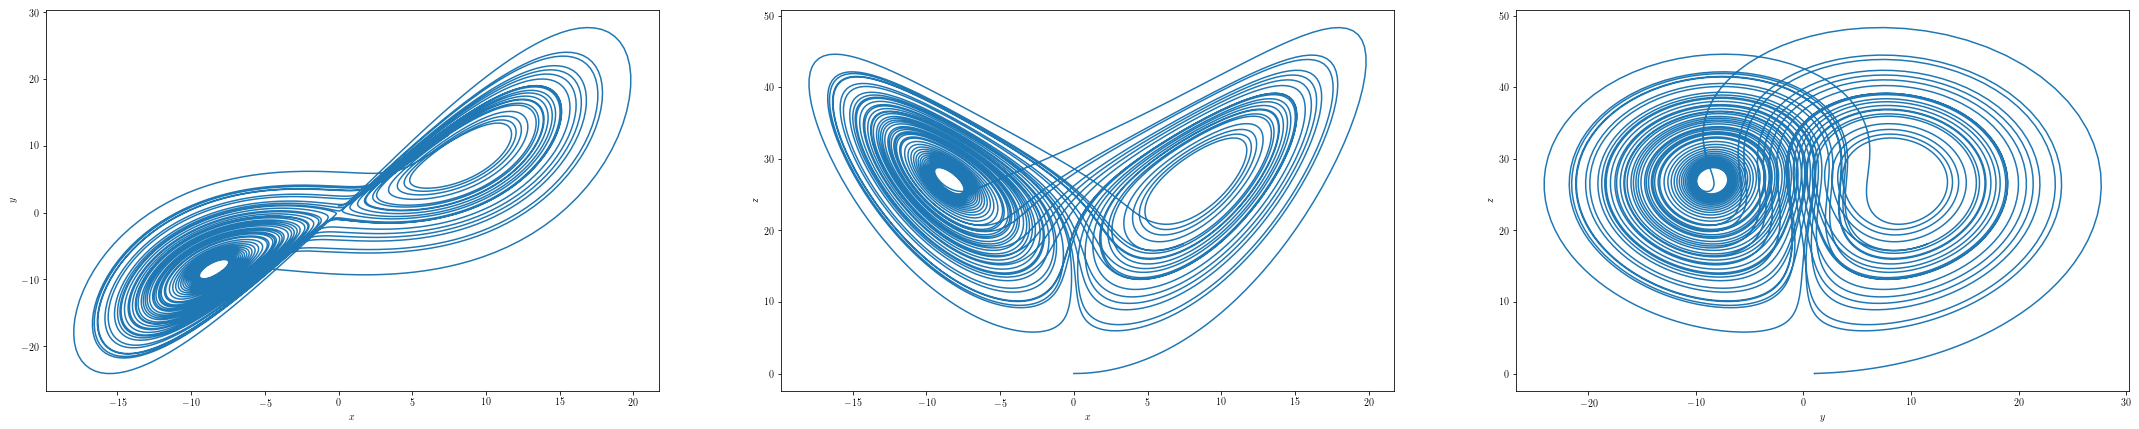

In [10]:
x,y,z = lorenz()

fig,(ax1,ax2,ax3) = mp.subplots(ncols=3, figsize=(7*3*16/9,7))

ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$y$")
ax1.plot(x,y)

ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$z$")
ax2.plot(x,z)

ax3.set_xlabel(r"$y$")
ax3.set_ylabel(r"$z$")
ax3.plot(y,z)

mp.show()

In [13]:
def chaotic_pendulum(m1,m2,l1,l2):
    
    g = 9.81
    
    def derivs(r,t):
        th1, w1, th2, w2 = r
        dth1 = w1
        dth2 = w2
        dw1 = (-g*(2*m1 + m2)*np.sin(th1) - m2*g*np.sin(th1 - 2*th2) - 2*np.sin(th1 - th2)*m2*(w2**2*l2 + w1**2*l1*np.cos(th1 - th2)))/ \
                (l1*(2*m1 + m2 - m2*np.cos(2*th1 - 2*th2)))
        dw2 = (2*np.sin(th1 - th2)*(w1**2*l1*(m1 + m2) + g*(m1 + m2)*np.cos(th1) + w2**2*l2*m2*np.cos(th1 - th2)))/ \
                (l2*(2*m1 + m2 - m2*np.cos(2*th1 - 2*th2)))
        return np.array([dth1,dw1,dth2,dw2], float)

    pend = rksolve_generalized(derivs)
    r0 = np.radians(np.array([120.0 , 0.0 , -10.0 , 0.0 ], float))
    pend.init_conds = r0
    dt = 0.05
    pend.rk4_step(0.0,20.0,dt)
    y = pend.phase_solution

    x1 = l1*np.sin(y[:,0])
    y1 = -l1*np.cos(y[:,0])
    x2 = l2*np.sin(y[:,2]) + x1
    y2 = -l2*np.cos(y[:,2]) + y1

    fig = mp.figure()
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2,2), ylim=(-2,2))
    ax.grid(True)

    line, = ax.plot([], [], "o-", lw=2)
    time_template = r"\textrm{time = %.2fs}"
    time_text = ax.text(0.05, 0.9, "", transform=ax.transAxes)

    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text

    def animate(i):
        thisx = [0, x1[i], x2[i]]
        thisy = [0, y1[i], y2[i]]

        line.set_data(thisx, thisy)
        time_text.set_text(time_template %(i*dt))
        return line, time_text

    chaos = anim.FuncAnimation(fig, animate, np.arange(1, len(y)), interval=25, blit=True, init_func=init)
    #chaos.save('chaotic_pendulum.mp4', fps=30, writer="ffmpeg")
    #mp.show()

In [ ]:
class Simulation(object):
    r = 0.25
    a = 0.7
    lims = 3.0
    dt = 0.1
    pstep = 3*np.pi
    poncaire = False

    def derivs(self, t, y):
        # add a docstring to this function
        '''
        Return first time derivative of phi and omega.
        
        Parameters
        ----------
        t : float
            Time
        y : array_like
            Contains phi and omega            
        '''
        return np.array([y[1], - self.r*y[1] - np.sin(y[0]) + self.a*np.cos(2./3.*t)])
    
    def rk4_step(self, f, x, y, h):
        # add a docstring to this function
        '''
        Perform a 4th order Runge-Kutta (RK4) to solve differential equation.
        
        Parameters
        ----------
        f : function
            Differential equation to be solved.
        x : float
            Argument of function f. Function f is differentiated with respect to x.
        y : float
            Argument of function f.
        h : float
            Step size for the RK4.
        '''
        k1 = h*f(x, y)
        k2 = h*f(x + 0.5*h, y + 0.5*k1)
        # complete the following lines
        k3 = h*f(x + 0.5*h, y + 0.5*k2)
        k4 = h*f(x + h, y + 0.5*k3)
        return np.array(y + k1/6. + k2/3. + k3/3. + k4/6.)
    
    def update(self, frame, line, f, x, h, pstep):
        # add a docstring to this function
        '''
        Solve phi and omega from the differential equations and plot the corresponding points.
        
        Parameters
        ----------
        line : matplotlib.lines.Line2D      
            Contains data for plotting.
        f : function
            Differential equation to be solved.
        x : float
            Argument of function f. Function f is differentiated with respect to x.
        h : float
            Step size for the RK4.
        pstep : float
            Step size for the RK4.
        '''
        if self.poncaire:
            self.y.append(self.rk4_step(f, frame*h, self.y[-1], pstep))
        else:
            self.y.append(self.rk4_step(f, frame*h, self.y[-1], h))
        xs, ys = zip(*self.y)
        line.set_xdata(xs)
        line.set_ydata(ys)
    
    def continue_loop(self):
        # add a docstring to this function
        '''
        Create a function generator.
        '''
        i = 0
        while 1:
            i += 1
            # what does yield do?
            '''It outputs a generator instead of an iterable'''
            
            # what will happen if return is used instead of yield?
            '''The animation will not run since the program will immediately get out 
            of the function once i is returned.'''
            
            yield i
    
    def on_key(self, event):
        key = event.key
        if key == 'i':
            self.a += 0.01
            self.info_text.set_text("$r$ = %0.2f\t$a$ = %0.6f" % (self.r,
                                                                  self.a))
        # add analogous code such that pressing "d" will decrease a by 0.01
        elif key == 'd':
            self.a -= 0.01
            self.info_text.set_text("$r$ = %0.2f\t$a$ = %0.6f" % (self.r,
                                                                  self.a))

        elif key == '+':
            self.lims /= 2
            plt.xlim(-self.lims, self.lims)
            plt.ylim(-self.lims, self.lims)
        # add analogous code such that pressing "-" will zoom out the plot
        elif key == '-':
            self.lims *= 2
            plt.xlim(-self.lims, self.lims)
            plt.ylim(-self.lims, self.lims)

        elif key == 't':
            self.poncaire = not self.poncaire
            if self.poncaire:
                self.line.set_linestyle('')
                self.line.set_marker('.')
                self.y = [np.array([np.pi/2, 0])]
            else:
                self.line.set_linestyle('-')
                self.line.set_marker('')
                self.y = [np.array([np.pi/2, 0])]
    
    def run(self):
        fig = mp.figure()
        # what are the other possible events?
        '''button_press_event, button_release_event, draw_event, key_release_event, etc.'''
        
        fig.canvas.mpl_connect('key_press_event', self.on_key)
    
        self.y = [np.array([np.pi/2, 0])]
        self.line, = mp.plot([], [])
        mp.xlim(-self.lims, self.lims)
        mp.ylim(-self.lims, self.lims)
        self.info_text = mp.figtext(0.15, 0.85, "$r$ = %0.2f\t$a$ = %0.6f" % (self.r, self.a))
        ani = anim.FuncAnimation(fig, self.update, self.continue_loop, 
                             fargs=(self.line, self.derivs, 0, self.dt, self.pstep),
                             interval=25, repeat=False)
        mp.show()